# Phishing Investigation Playbook Workshop

This workshop provides a comprehensive playbook for investigating phishing emails using the full suite of CIRCL threat intelligence tools. The playbook demonstrates how to systematically analyze a phishing email, extract and enrich indicators, and document findings in MISP for threat intelligence sharing.

## What is a Phishing Investigation Playbook?

A phishing investigation playbook is a systematic approach to analyzing suspicious emails and their associated infrastructure. It combines multiple threat intelligence sources and analysis techniques to:
- **Extract Indicators**: Identify URLs, domains, IP addresses, file hashes, and other IOCs
- **Enrich Intelligence**: Gather comprehensive information about each indicator
- **Correlate Data**: Connect findings across multiple intelligence sources
- **Assess Threats**: Evaluate the scope and impact of the phishing campaign
- **Document Findings**: Create structured threat intelligence for sharing and defense

## Investigation Methodology

The playbook follows a structured approach:
1. **Email Analysis**: Parse and extract basic indicators from the phishing email
2. **Infrastructure Analysis**: Investigate domains, IPs, and network infrastructure
3. **URL Analysis**: Examine suspicious links and their behavior
4. **File Analysis**: Analyze any attachments for malicious content
5. **Historical Correlation**: Search for related campaigns and activities
6. **Intelligence Fusion**: Combine findings into comprehensive threat assessment
7. **Documentation**: Create MISP event with all findings and relationships

## Tools Integration

The playbook integrates all workshop tools:
- **MISP**: Central threat intelligence platform for documentation and sharing
- **PassiveDNS**: Historical DNS resolution data for infrastructure analysis
- **Lookyloo**: Website behavior analysis and screenshot capture
- **BGP-Ranking**: Network infrastructure reputation and risk assessment

## Learning Objectives

By completing this workshop, you will learn to:
- Parse phishing emails and extract threat indicators systematically
- Apply multiple threat intelligence tools in a coordinated investigation workflow
- Correlate findings across different intelligence sources for comprehensive analysis
- Build detailed threat profiles combining infrastructure, behavioral, and historical intelligence
- Create structured MISP events with proper attribution and relationship mapping
- Develop automated workflows for phishing investigation and response
- Generate actionable intelligence for organizational defense and threat hunting

## Prerequisites

Before starting the investigation, ensure you have:
- Access to all CIRCL services with valid API credentials
- Sample phishing email in .eml format
- MISP instance access
- All required Python libraries installed

## Task 1: Email Parsing and Initial IOC Extraction

**Objective**: Parse the .eml file and extract basic indicators of compromise (IOCs).

**Actions**:
- Parse email headers (sender, recipient, subject, message-ID, routing information)
- Extract embedded URLs from email body and HTML content
- Extract sender IP addresses and email infrastructure details
- Identify domains from URLs and email addresses
- Create initial IOC inventory for subsequent analysis

In [20]:
import re
from pymisp.tools import EMailObject

# Use the EMailObject tool to parse the .eml file
# This tool automatically generates a MISP Object with multiple attributes extracted from the email headers
email_object = EMailObject("../files/netflix_phishing.eml")

# Extract email body
body = "\n".join(
    [attr.value for attr in email_object.attributes if attr.type == "email-body"]
)

# Extract email headers
headers_raw = next(
    (attr.value for attr in email_object.attributes if attr.type == "email-header")
)
headers = headers_raw.split("\n")

# Extract email source addresses
sources = [attr.value for attr in email_object.attributes if attr.type == "email-src"]
print("\nExtracted Source Emails:")
for src in sources:
    print(f" - {src}")

# Extract hostnames
hostnames = [attr.value for attr in email_object.attributes if attr.type == "hostname"]
print("\nExtracted Hostnames:")
for hostname in hostnames:
    print(f" - {hostname}")

# Extract ips
ips = [
    attr.value
    for attr in email_object.attributes
    if attr.type == "ip-src" or attr.type == "ip-dst"
]
print("\nExtracted IPs:")
for ip in ips:
    print(f" - {ip}")

# Extract URLs from the email body using regex
urls = re.findall(r'https?://[^\s\'"<>]+', body)

print("\nExtracted URLs:")
for url in urls:
    print(f" - {url}")


Extracted Source Emails:
 - no_reply@netflix.com
 - villagedeifiori@valorum.dnshigh.com

Extracted Hostnames:
 - redacted-recipient-host.com
 - valorum.dnshigh.com

Extracted IPs:
 - 185.194.93.129
 - 86.107.32.92

Extracted URLs:
 - https://shorturl.asia/fZI21
 - https://help.netflix.com/support/365
 - https://help.netflix.com/contactus
 - https://www.netflix.com/ManageSubscriptions
 - https://www.netflix.com/TermsOfUse
 - https://www.netflix.com/PrivacyPolicy
 - https://help.netflix.com/help


## Task 2: Website Behavior Analysis - Lookyloo

**Objective**: Capture and analyze the behavior of phishing websites and URLs.

**Actions**:
- Submit all identified phishing URLs to Lookyloo for analysis
- Capture screenshots and document visual phishing techniques
- Analyze network connections, redirects, and resource loading patterns
- Identify additional infrastructure through website behavior analysis

**Expected Outputs**: Website screenshots, network behavior data, and evasion technique documentation.

**Implementation Notes**:
- Submit suspicious extracted URLs to Lookyloo for capture and analysis
- Download and analyze screenshots for visual phishing techniques
- Extract network connections, redirects, and additional domains/IPs
- Document website behavior patterns and technical indicators

In [21]:
from pylookyloo import Lookyloo

lookyloo = Lookyloo()

phishing_url = "https://shorturl.asia/fZI21"

print(f"Enqueuing URL for analysis: {phishing_url}")
capture_uuid = lookyloo.submit(quiet=True, url=phishing_url)
print(f"URL enqueued successfully. Capture URL: https://lookyloo.circl.lu/tree/{capture_uuid}")

Enqueuing URL for analysis: https://shorturl.asia/fZI21
URL enqueued successfully. Capture URL: https://lookyloo.circl.lu/tree/6cda36ea-1d94-488e-9e99-e817f21d0013


In [22]:
import time

capture_info = lookyloo.get_info(capture_uuid)
retries = 0
while 'error' in capture_info and capture_info['error'].startswith('Unable to find UUID'):
    if retries >= 10:
        print("Maximum retries reached. Please check back later.")
        break
    print("Capture is still being processed. Checking back in 10 seconds...")
    retries += 1
    time.sleep(10)
    capture_info = lookyloo.get_info(capture_uuid)

print("Capture Info:")
for key, value in capture_info.items():
    print(f"  {key}: {value}")

Capture is still being processed. Checking back in 10 seconds...
Capture is still being processed. Checking back in 10 seconds...
Capture is still being processed. Checking back in 10 seconds...
Capture Info:
  capture_time: 2025-11-13T08:58:36.338000+00:00
  referer: 
  title: 403 Forbidden
  url: https://shorturl.asia/fZI21
  user_agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.7390.37 Safari/537.36
  uuid: 6cda36ea-1d94-488e-9e99-e817f21d0013


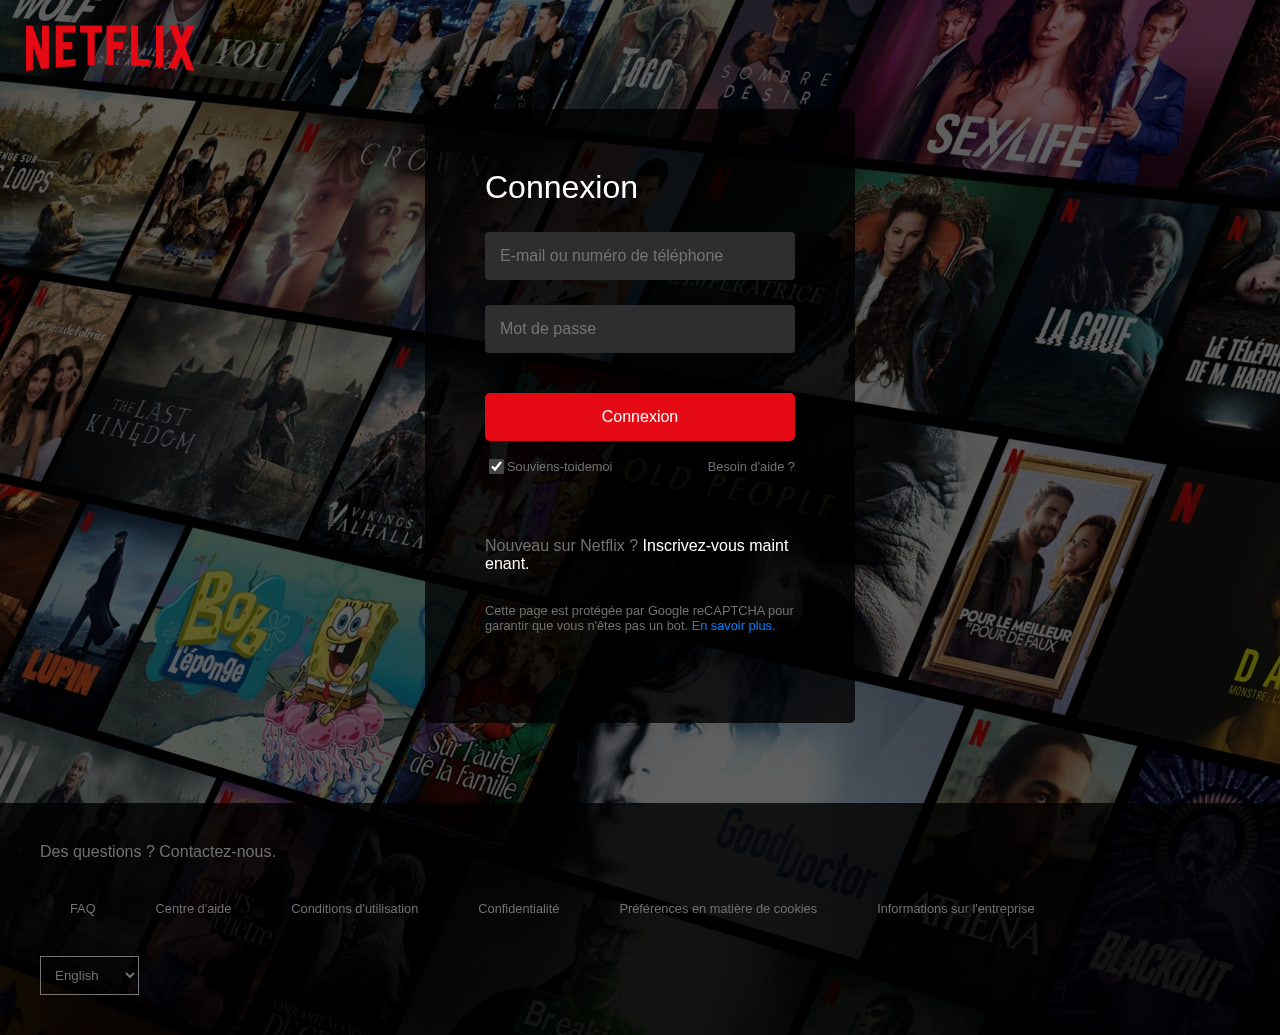

In [67]:
from PIL import Image
capture_screenshot = lookyloo.get_screenshot(capture_uuid)

image = Image.open(capture_screenshot)
display(image)

In [6]:
response = lookyloo.get_hostnames(capture_uuid)

capture_domains = []

print("Hostnames associated with the capture:")
for host in response['response']['hostnames']:
    print(f" - {host}")
    capture_domains.append(host)

Hostnames associated with the capture:
 - www.netsmtsolutions.ch
 - chacktgbot.duckdns.org
 - www.lanaciondigital.es
 - shorturl.asia


In [7]:
response = lookyloo.get_ips(capture_uuid)

capture_ips = []

print("IPs associated with the capture:")
for ip in response['response']['ips']:
    print(f" - {ip}")
    capture_ips.append(ip)

IPs associated with the capture:
 - 2a0a:4cc0:5:405::20:8537
 - 217.160.32.97
 - 2606:4700:20::ac43:4568


## Task 2: Domain Infrastructure Analysis - PassiveDNS

**Objective**: Analyze DNS resolution history for all identified domains to understand infrastructure patterns.

**Actions**:
- Query PassiveDNS for historical DNS records of phishing domains
- Identify hosting infrastructure and IP address changes over time
- Analyze subdomain patterns and domain registration activity
- Correlate DNS timing with campaign activity and infrastructure setup
- Identify additional related domains through shared IP addresses

**Expected Outputs**: Historical DNS data, infrastructure timeline, and related domain discoveries.

**Implementation Notes**:
- Query each extracted domain against PassiveDNS API
- Analyze A, AAAA, and CNAM records for infrastructure patterns
- Build timeline of DNS changes to understand campaign deployment

### Task 2.1 - Initialize PassiveDNS Client

In [24]:
import pypdns
import json
import getpass

# Securely collect PassiveDNS credentials
print("Setting up PassiveDNS API authentication...")
PASSIVE_DNS_USER = getpass.getpass("Enter your PassiveDNS Username: ")
PASSIVE_DNS_KEY = getpass.getpass("Enter your PassiveDNS API Key: ")

# Create PassiveDNS client with authentication
pdns = pypdns.PyPDNS(basic_auth=(PASSIVE_DNS_USER, PASSIVE_DNS_KEY))

Setting up PassiveDNS API authentication...


Enter your PassiveDNS Username:  ········
Enter your PassiveDNS API Key:  ········


### Task 2.2 - Enrich hostnames with PassiveDNS

In [25]:
from pymisp import MISPObject

domains = []

capture_domains = [ "www.netsmtsolutions.ch", "chacktgbot.duckdns.org", "www.lanaciondigital.es", "shorturl.asia"]
capture_ips = ["2a0a:4cc0:5:405::20:8537", "217.160.32.97", "2606:4700:20::ac43:4568"]


for host in capture_domains:

    # Create MISP domain-ip object
    # see: https://www.misp-project.org/objects.html#_domain_ip
    domain = MISPObject(name="domain-ip")
    domain.add_attribute("hostname", value=host)
    first_seen = None
    last_seen = None
    
    
    # Get DNS A records from PassiveDNS
    records = list(pdns.query(q=host, timeout=10))
    print(f"PassiveDNS records found for domain: {host}")
    if records:
        for record in records:
            if host == record["rdata"] and record["rrtype"] in ['A', 'AAAA']:
                domain.add_attribute("ip", value=record["rrname"])
                if first_seen is None or record["time_first"] < first_seen:
                    first_seen = record["time_first"]
                if last_seen is None or record["time_last"] > last_seen:
                    last_seen = record["time_last"]

    else:
        print(" No A records found.")

    if first_seen:
        domain.add_attribute("first-seen", value=first_seen)
    if last_seen:
        domain.add_attribute("last-seen", value=last_seen)

    domains.append(domain)

print(f"Created {len(domains)} MISP domain-ip objects from email analysis.")

PassiveDNS records found for domain: www.netsmtsolutions.ch
PassiveDNS records found for domain: chacktgbot.duckdns.org
PassiveDNS records found for domain: www.lanaciondigital.es
PassiveDNS records found for domain: shorturl.asia
Created 4 MISP domain-ip objects from email analysis.


### Task 2.3 - Enrich IPs with domains

In [26]:
pdns_domains = []
for ip in capture_ips:
    print(f"\nQuerying PassiveDNS for IP: {ip}")

    # Get DNS records for the IP address from PassiveDNS
    records = list(pdns.query(q=ip, timeout=10))

    if records:
        print(f"Successfully retrieved {len(records)} DNS records!")
        for record in records[:10]:  # Limit to first 10 records for brevity
            if record["rrtype"] in ["A", "AAAA"]:
                # Create MISP domain-ip object
                # see: https://www.misp-project.org/objects.html#_domain_ip
                domain = MISPObject(name="domain-ip")
                domain.add_attribute("hostname", value=record["rrname"])
                domain.add_attribute("ip", value=ip)
                domain.add_attribute("first-seen", value=record["time_first"])
                domain.add_attribute("last-seen", value=record["time_last"])
                pdns_domains.append(domain)

print(f"Created {len(pdns_domains)} MISP domain-ip objects from email analysis.")


Querying PassiveDNS for IP: 2a0a:4cc0:5:405::20:8537
Successfully retrieved 2 DNS records!

Querying PassiveDNS for IP: 217.160.32.97
Successfully retrieved 5 DNS records!

Querying PassiveDNS for IP: 2606:4700:20::ac43:4568
Successfully retrieved 1000 DNS records!
Created 17 MISP domain-ip objects from email analysis.


## Task 3: MISP Event Creation

**Objective**: Create a preliminary MISP event structure to document the phishing investigation.

**Actions**:
- Create new MISP event with appropriate threat level and classification
- Add basic email metadata as attributes (sender, subject, timestamps)
- Create initial attribute placeholders for discovered IOCs
- Set event tags for phishing campaign and threat actor classification
- Establish event relationships and correlation framework

**Expected Outputs**: MISP event UUID and structured framework for investigation documentation.

**Implementation Notes**:
- Use PyMISP to create event with proper threat level and distribution settings
- Add email-specific attributes: sender, recipient, subject, message-ID
- Create placeholder attributes for IOCs to be enriched in subsequent tasks
- Apply appropriate taxonomies and tags for phishing classification
- Set up event structure for adding enrichment data from other tools

### Task 3.1 - Initialize MISP Client

In [30]:
import pymisp
import urllib3
import getpass

MISP_BASEURL = "https://training.misp-community.org"
MISP_API_KEY = getpass.getpass("Enter your MISP AuthKey:")

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

misp = pymisp.PyMISP(
    MISP_BASEURL,
    MISP_API_KEY,
    ssl=False # Disable SSL verification
)
print(f"Connected to MISP {misp.root_url} running version: {misp.version['version']}")


Enter your MISP AuthKey: ········


Connected to MISP https://training.misp-community.org running version: 2.5.17.2


### Task 3.2 - Create MISP Event

In [ ]:
from pymisp import MISPEvent
from defang import defang

event = MISPEvent()

event.info = 'Phishing Site: ' + defang(phishing_url)
event.distribution = 3  # All Communities
event.threat_level_id = 2  # Medium
event.analysis = 1  # Ongoing Analysis

# Add email object to the event
event.add_object(email_object)
for domain in domains:
    event.add_object(domain)
for domain in pdns_domains:
    event.add_object(domain)

# Add phishing URL as attribute
event.add_attribute(type="url", value=phishing_url, to_ids=True, comment="Phishing URL identified in the email")

# Add screenshot
event.add_attribute(type="attachment", value="screenshot.png", data=capture_screenshot)

# Add Tags
event.add_tag("tlp:clear")
event.add_tag("tlp:white")
event.add_tag("phishing:state=\"active\"")
event.add_tag("misp-galaxy:mitre-attack-pattern=\"Phishing - T1566\"")

# Add the event to MISP
misp_event = misp.add_event(event)
print(f"Event created successfully with UUID: {misp_event['Event']['uuid']}")

Event created successfully with UUID: dd2a89cd-41f0-4a2f-93ce-9faee0193c92


In [60]:
# open file and add attribute
from io import BytesIO


local_file = "../files/screenshot.png"
with open(local_file, "rb") as f:
    event.add_attribute(type="attachment", value="screenshot.png", data=BytesIO(f.read()))

misp.update_event(event)

{'Event': {'id': '144',
  'orgc_id': '15',
  'org_id': '15',
  'date': '2025-11-13',
  'threat_level_id': '2',
  'info': 'Phishing Site: hXXps://shorturl[.]asia/fZI21',
  'published': True,
  'uuid': 'dd2a89cd-41f0-4a2f-93ce-9faee0193c92',
  'attribute_count': '149',
  'analysis': '1',
  'timestamp': '1763028370',
  'distribution': '0',
  'proposal_email_lock': False,
  'locked': False,
  'publish_timestamp': '1763028371',
  'sharing_group_id': '0',
  'disable_correlation': False,
  'extends_uuid': '',
  'protected': None,
  'event_creator_email': 'luciano.righetti@circl.lu',
  'Org': {'id': '15',
   'name': 'CIRCL',
   'uuid': '55f6ea5e-2c60-40e5-964f-47a8950d210f',
   'local': True},
  'Orgc': {'id': '15',
   'name': 'CIRCL',
   'uuid': '55f6ea5e-2c60-40e5-964f-47a8950d210f',
   'local': True},
  'Attribute': [{'id': '9504',
    'type': 'url',
    'category': 'Network activity',
    'to_ids': True,
    'uuid': '40c134cf-4897-449a-a160-3a320759e0bd',
    'event_id': '144',
    'distri

## Task 4: Enrich Data with `misp-modules`

**Objective**: Compare MISP‑modules enrichment capabilities with calling enrichment APIs manually and recommend when to use each

- What `misp‑modules` provide
    - Unified interface inside MISP: one place to launch enrichments and attach results to events/attributes.
    - Pre-built connectors: many common enrichers (PassiveDNS, WHOIS, VirusTotal, BGP, mmdb, etc.) implemented with standardized input/output.
    - Automatic object/attribute creation: results can be converted to MISP attributes/objects and linked to events with minimal effort.
    - Consistency & reproducibility: modules follow MISP data model and tagging conventions, making results easier to correlate.
    - Security and separation: modules can be run in isolated workers and centrally configured (API keys stored server-side).

- What calling APIs manually gives you
    - Full control & flexibility: custom queries, bespoke parsing, custom correlation logic, and the ability to combine multiple data sources in non-standard ways.
    - Performance tuning: batch requests, parallelism, and tailored rate‑limit handling for large enrichments.
    - Latest/advanced features: use newest provider APIs or vendor-specific endpoints not yet implemented in MISP‑modules.
    - Fine-grained error handling & logging: implement custom retries, backoff, and circuit breakers to match your infra.
    - Integration options: feed results into other systems (SIEM, custom DBs, automation playbooks) without first serializing into MISP.

- Trade-offs & when to choose which
    - Use MISP‑modules when you want fast analyst-driven enrichment, standardized output inside MISP, low development cost, and secure centralized API key management.
    - Use direct API calls when you need custom enrichment logic, higher throughput, advanced API features, or to integrate results into non‑MISP pipelines.
    - Hybrid approach: use MISP‑modules for exploratory analyst work and quick sharing; implement custom API clients for automation, scale, and advanced correlation, then push summarized results back into MISP.

- Practical tip
    - Start with `misp‑modules` to onboard analysts quickly and to standardize outputs. For production automation or high-volume workflows, implement tailored API clients or small adapter services that normalize results back into the MISP schema.

In [ ]:
misp.enrich_event(event.uuid, enrich_with=["bgp-ranking", "mmdb_lookup"])

## Task 5: Summary and Publication
- Summary of findings
    - The phishing campaign uses a short redirector (shorturl.asia) that resolves to a cluster of suspicious hostnames discovered during the Lookyloo capture and PassiveDNS enrichment.
    - Extracted IOCs include sender addresses from the parsed .eml, embedded URLs, hostnames observed in the capture, and associated IP addresses collected from Lookyloo and PassiveDNS.
    - Lookyloo analysis produced a full-page screenshot and network behavior data showing redirects and third‑party resource loading consistent with credential-harvesting pages.
    - PassiveDNS queries revealed historical A/AAAA records and additional related hostnames tied to the campaign infrastructure, enabling linkage between domains and IPs.
    - Enrichment via bgp-ranking and mmdb_lookup provided network reputation and geolocation context for the observed IPs, supporting prioritization of response.

- Actions taken
    - All discovered domains, IPs, and the phishing URL were recorded as MISP objects and attributes; a MISP event was created and published for sharing and tracking.
    - A screenshot attachment and contextual tags (phishing, TLP) were added to the event for analyst consumption.

- Recommended next steps
    - Block the identified domains and IPs at perimeter controls and add detections for the short URL pattern and email sender indicators.
    - Monitor DNS and PassiveDNS for newly observed domains sharing the same IP space or certificate material.
    - Share the MISP event with relevant internal teams and partner organizations to accelerate detection and remediation.

In [ ]:
misp.publish(event.uuid)

![image](../files/misp_netflix_phising_event.png)